In [91]:
# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from matplotlib import cm
from scipy.optimize import minimize
from scipy.special import logsumexp

from density import get_projected_coords, get_u_v, get_uniform_idx, DensityModel2D
from likelihood import z_to_a, a_to_z, Model

## Make fake data where we know the answer:

In [92]:
from sklearn.mixture import GaussianMixture

In [93]:
D = 2
h = 1.

In [94]:
rnd = np.random.RandomState(22)
true_K = 2
true_nodes = np.stack((np.linspace(0, 10, true_K),
                       np.zeros(true_K))).T
true_s = rnd.uniform(0.2, 0.5, size=true_K)

true_z = rnd.uniform(0.8, 0.95, size=true_K-1)
true_a = z_to_a(true_z)
assert np.isclose(true_a.sum(), 1.)

# Sample from truth:
C = np.zeros((true_K, D, D))
C[:, 0, 0] = h**2
C[:, 1, 1] = true_s**2

P = np.zeros_like(C)
for k in range(true_K):
    P[k] = np.linalg.cholesky(np.linalg.inv(C[k]))

gmm = GaussianMixture(n_components=true_K, covariance_type='full')
gmm.fit(np.random.random(size=(true_K+1, 2)))
gmm.weights_ = true_a
gmm.covariances_ = C
gmm.precisions_cholesky_ = P
gmm.means_ = true_nodes

# now add a uniform background
n_samples_total = 100000
true_f = 0.85
bounds = [[-5, 15], [-5, 5]]
n_stream = int(true_f * n_samples_total)
gmm_X = gmm.sample(n_samples=n_stream)[0]

n_bg = n_samples_total - n_stream
unif_X = np.stack([np.random.uniform(b[0], b[1], size=n_bg) 
                   for b in bounds]).T
X = np.vstack((gmm_X, unif_X))

In [95]:
true_dens_model = DensityModel2D(X)
true_dens_model.poly = np.poly1d([0.])
track = true_dens_model.get_dense_poly_track(size=10000)
nodes = true_dens_model.set_nodes(track=track, nodes=true_nodes)
model = Model(true_dens_model, h=h, l=0.1)

In [96]:
p0 = {'ln_s': np.log(true_s),
      'ln_z': np.log(true_z),
      'm': np.zeros(true_K)}
_x0 = model.pack_pars(**p0)
true_x = np.concatenate(([true_f], _x0))

In [97]:
# dens_model = DensityModel2D(X)
# track = dens_model.get_dense_poly_track(size=10000)
# nodes = dens_model.set_nodes(spacing=1.5, track=track)

(-5, 5)

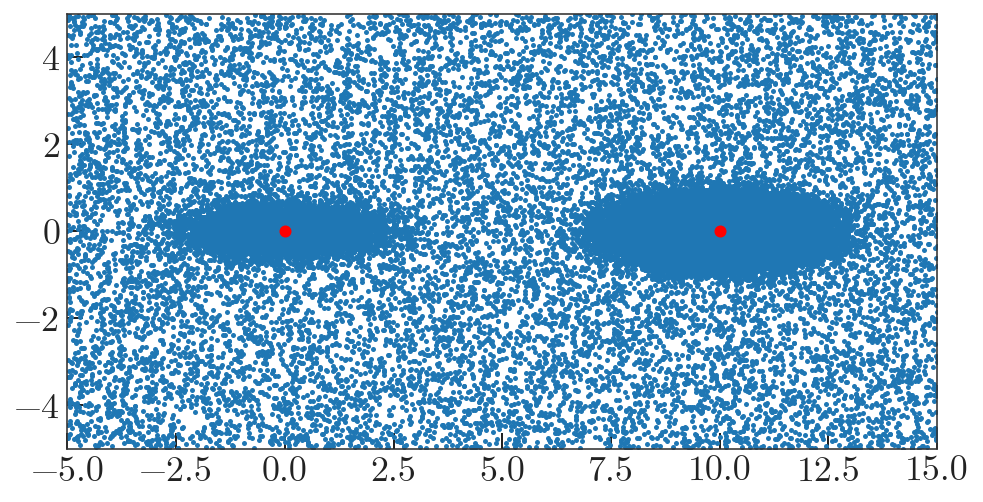

In [98]:
plt.figure(figsize=(10, 4))
plt.plot(X[:, 0], X[:, 1], marker='.', ls='none')
plt.scatter(true_nodes[:, 0], true_nodes[:, 1], zorder=10, color='r')
# plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='k')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlim(-5, 15)
ax.set_ylim(-5, 5)

In [99]:
K = true_dens_model.K
print(K)

# f0 = 0.85
# sk0 = true_s
# z0 = true_z
# m0 = np.zeros(K)

f0 = 0.5
sk0 = np.ones(K)
z0 = a_to_z(np.ones(K)/K)
m0 = np.zeros(K)

p0 = {'ln_s': np.log(sk0),
      'ln_z': np.log(z0),
      'm': m0}
_x0 = model.pack_pars(**p0)
x0 = np.concatenate(([f0], _x0))

2


In [100]:
from scipy.stats import multivariate_normal as mvn
def ln_derivs_like(self, p):
    """Log of the derivatives of the *likelihood*, not the log-likelihood!"""

    R = self.density_model._R_k
    K = self.density_model.K
    X = self.density_model.X
    h = self.h
    (N, D) = X.shape

    a = self.get_a(p)
    s = self.get_s(p)
    z = self.get_z(p)
    nodes = self.get_mu(p)

    # We need this for all of the derivatives
    ln_N_nk = np.zeros((N, K))
    C = np.zeros((K, D, D))
    Cinv = np.zeros((K, D, D))
    for k in range(K):
        C[k] = self.density_model.get_Ck(k, s[k], h)
        Cinv[k] = self.density_model.get_Ck(k, s[k], h, inv=True)
        ln_N_nk[:, k] = mvn.logpdf(X, nodes[k], C[k],
                                   allow_singular=True)
    ln_aN_nk = np.log(a) + ln_N_nk

    # ---
    ln_d_L_d_a = ln_N_nk
    ln_d_L_dznk = np.zeros((N, K-1))
    z_sign = np.ones((N, K-1))
    for k in range(K-1):
        # note the change: z-1 to 1-z and minus sign out front
        ln_t1 = np.log(a[k]) - np.log(1 - z[k]) + ln_d_L_d_a[:, k]
        
        terms = []
        for j in range(k+1, K):
            terms.append(np.log(a[j]) - np.log(z[k]) + ln_d_L_d_a[:, j])
        ln_t2 = logsumexp(terms, axis=0)
        
        ln_d_L_dznk[:, k], z_sign[:, k] = logsumexp([ln_t1, ln_t2], 
                                                    b=[np.ones(N), -np.ones(N)], 
                                                    axis=0, return_sign=True)
    ln_d_L_d_lnznk = ln_d_L_dznk + np.log(z)
    
    # ---
    ln_d_L_d_mnk = np.zeros((N, K))
    m_sign = np.zeros((N, K))
    for k in range(K):
        # the [:,1] below picks off only the y term, because we only allow
        # the means to move in y
        Cinv_dx = np.einsum('ij,nj->ni', Cinv[k], X - nodes[k:k+1])[:, 1]
        m_sign[:, k] = np.sign(Cinv_dx)
        log_Cinv_dx = np.log(np.abs(Cinv_dx))
        ln_d_L_d_mnk[:, k] = ln_aN_nk[:, k] + log_Cinv_dx

    # ---
    ln_d_L_d_snk = np.zeros((N, K))
    s_sign = np.zeros((N, K))
    for k in range(K):
        b = X - nodes[k:k+1]

        term = ((b[:, 1]*R[k,0,0] + b[:, 0]*R[k,0,1])**2/s[k]**2 - 1) / s[k]

        s_sign[:, k] = np.sign(term)
        log_term = np.log(np.abs(term))

        ln_d_L_d_snk[:, k] = ln_aN_nk[:, k] + log_term
    
    ln_d_L_d_lnsnk = ln_d_L_d_snk + np.log(s)
    
    return [[ln_d_L_d_lnsnk, s_sign],
            [ln_d_L_d_lnznk, z_sign],
            [ln_d_L_d_mnk, m_sign]]
    # return np.concatenate((d_L_d_lns, d_L_d_lnz, d_L_d_m))

In [101]:
# ln_derivs_like(model, p0)

In [102]:
def bg_ln_like():
    return np.sum([-np.log(b[1]-b[0]) for b in bounds])

def ln_total_likelihood(x):
    f = x[0]
    
    p = model.unpack_pars(x[1:])
    ll1 = model.ln_likelihood(p) + np.log(f)
    ll2 = bg_ln_like() + np.log(1-f)
    return np.logaddexp(ll1, ll2)

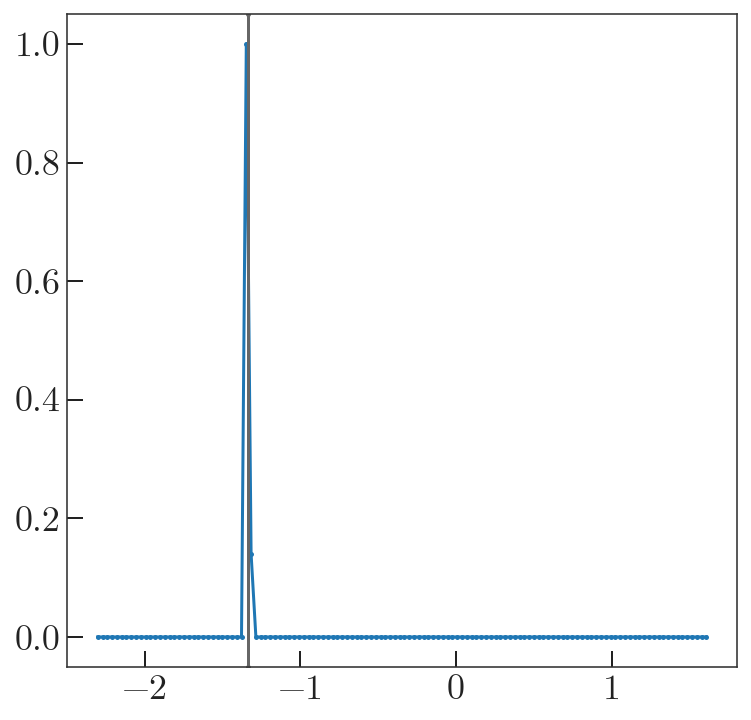

In [104]:
jj = 1
# vals = np.linspace(0.1, 1-1e-3, 128)
vals = np.linspace(np.log(0.1), np.log(5), 128)
lls = []
for val in vals:
    xx = true_x.copy()
    xx[jj] = val
    lls.append(ln_total_likelihood(xx).sum())
lls = np.array(lls)
plt.plot(vals, np.exp(lls - lls.max()))
plt.axvline(true_x[jj])

In [105]:
def ln_likelihood_deriv(x):
    f = x[0]
    gmm_x = x[1:]
    p = model.unpack_pars(gmm_x)
    
    ln_denom = ln_total_likelihood(x)
    
    # first, d/df
    N = model.density_model.N
    ln_fg = model.ln_likelihood(p)
    ln_bg = np.ones(N) * bg_ln_like()
    ln_numer, sign = logsumexp([ln_fg, ln_bg], 
                               b=np.stack((np.ones(N), -np.ones(N))),
                               return_sign=True, axis=0)

    d_df = sign * np.exp(ln_numer - ln_denom)
    f_deriv = d_df.sum()
    
    ss, zz, mm = ln_derivs_like(model, p)
    s_deriv = np.sum(ss[1] * np.exp(np.log(f) + ss[0] - ln_denom[:, None]), axis=0)
    z_deriv = np.sum(zz[1] * np.exp(np.log(f) + zz[0] - ln_denom[:, None]), axis=0)
    m_deriv = np.sum(mm[1] * np.exp(np.log(f) + mm[0] - ln_denom[:, None]), axis=0)
    
    return np.concatenate([[f_deriv], s_deriv, -z_deriv, m_deriv])

In [106]:
def func_helper(x):
    return -ln_total_likelihood(x).sum()

def num_deriv_helper(x):
    eps = 1e-10
    num_derivs = []
    for k in range(x.size):
        x1 = x.copy()
        x2 = x1.copy()
        x2[k] = x2[k] + eps
        _d = (func_helper(x2) - func_helper(x1)) / eps
        num_derivs.append(_d)
    return np.array(num_derivs)

def deriv_helper(x):
    return -ln_likelihood_deriv(x)

In [107]:
num_deriv_helper(x0)

array([-1.11454283e+05,  8.40693247e+03,  5.60184708e+04, -5.47023956e+04,
       -4.54019755e+01, -4.30736691e+01])

In [108]:
deriv_helper(x0)

array([-1.11455356e+05,  8.40661200e+03,  5.60182936e+04, -5.47035553e+04,
       -4.57790390e+01, -4.42688579e+01])

In [109]:
min_bounds = [[1e-5, 1-1e-5]] + [[-8, 4]]*K + [[-8, -1e-9]]*(K-1) + [[-5, 5]]*K

res = minimize(func_helper, jac=deriv_helper, 
               x0=x0, method='L-BFGS-B', 
               bounds=min_bounds,
               options=dict(ftol=1e-13))

In [110]:
assert res.success

In [111]:
x0

array([ 0.5       ,  0.        ,  0.        , -0.69314718,  0.        ,
        0.        ])

In [112]:
res.x

array([ 8.50197519e-01, -1.33650563e+00, -1.06626970e+00, -1.46014404e-01,
        4.53082399e-04,  4.04680081e-04])

Text(0.5,1,'fit with gradients')

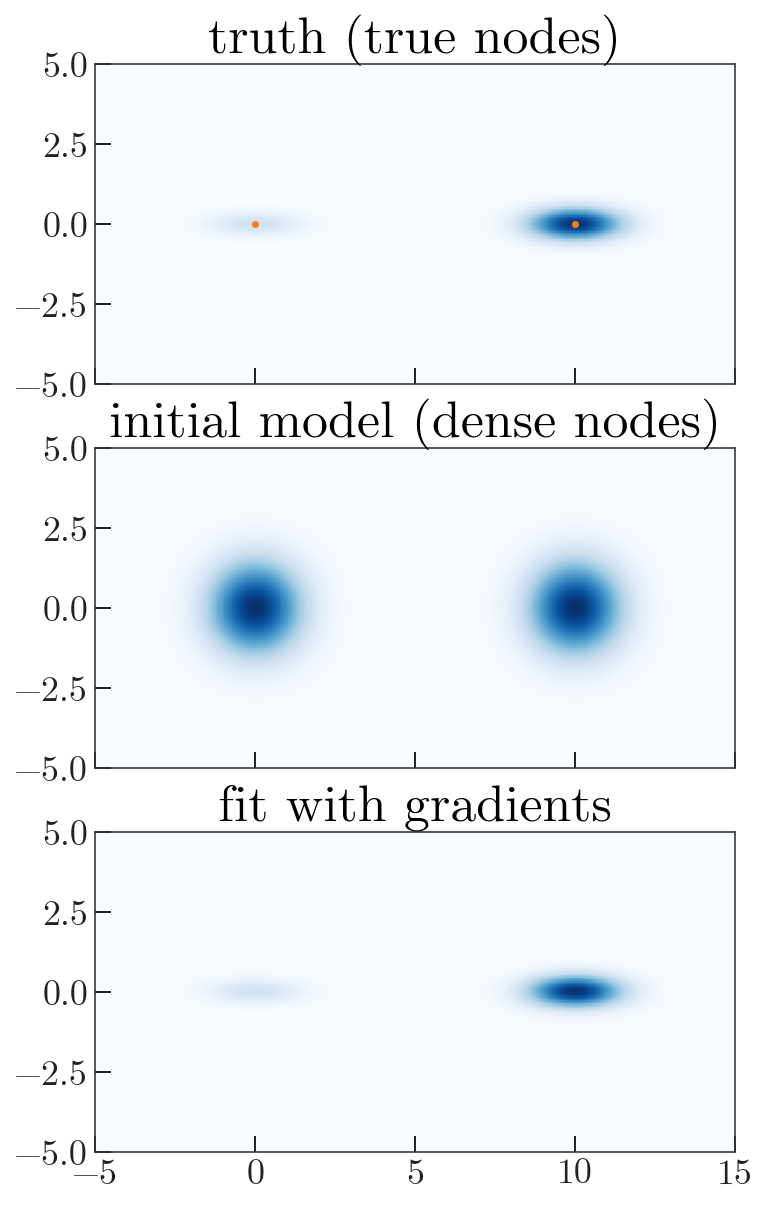

In [113]:
bins = (np.arange(-10, 15+1e-3, 0.05),
        np.arange(-5, 5+1e-3, 0.05))
x, y = np.meshgrid(*bins)
xy = np.stack((x.ravel(), y.ravel())).T

fig, axes = plt.subplots(3, 1, figsize=(10, 10), 
                         sharex=True, sharey=True)

ax = axes[0]
true_p = model.unpack_pars(true_x[1:])
ln_dens = model.ln_density(true_p, xy)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(true_nodes[:, 0], true_nodes[:, 1],
           marker='.', color='tab:orange')

ax = axes[1]
ln_dens = model.ln_density(p0, xy)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
# ax.scatter(true_dens_model.nodes[:, 0], true_dens_model.nodes[:, 1],
#            marker='.', color='tab:orange')

ax = axes[2]
best_p = model.unpack_pars(res.x[1:])
ln_dens = model.ln_density(best_p, xy)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
# ax.scatter(med_mu[:, 0], med_mu[:, 1],
#            marker='o', c=np.log(med_a))

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(-5, 15)

axes[0].set_title('truth (true nodes)')
axes[1].set_title('initial model (dense nodes)')
axes[2].set_title('fit with gradients')